

<figure>
<center>
<img src='https://adass2020.s3.amazonaws.com/logos.png' />
<figcaption></figcaption></center>
</figure>

# From Semantic segmentation to Instance Segmentation using DeepLearning
---

The tasks of location, classification, and segmentation are known and applied by astronomers in various problems such as: Morphological classification of galaxies, Transient detection, search for supernovae among others.

Is widely known in this decade will see a series of astronomical mega-projects coming into operation producing complex data whose dimensionality and volume will exceed any current scale. This requires the application of a new generation of machine learning (Deeplearning) models for classification, location, and segmentation.
In this tutorial we will cover the latest advances in Deep learning applied to Semantic segmentation, Object localization and Instance Segmentation. 

<figure>
<center>
<img src='https://adass2020.s3.amazonaws.com/unet1.png' />
<figcaption>Examples of the output of four different Computer Vision models applied to an astronomical image of galaxies</figcaption></center>
</figure>


# What is Semantic Segmentation?

The goal of semantic image segmentation is to label each pixel of an image with a corresponding class of what is being represented. The expected output in semantic segmentation are not just labels and bounding box parameters. The output itself is a high resolution image (typically of the same size as input image) in which each pixel is classified to a particular class. Thus it is a pixel level image classification.

# Fully Convolutional Network U-Net
----

In this tutorial, we will learn about semantic segmentation using a deep learning model called U-Net. This architecture was introduce in the paper **U-Net: Convolutional Networks for Biomedical Image Segmentation** that you can read there: https://arxiv.org/abs/1505.04597  

It is a Fully Convolutional neural network. The reason behind why it is named U-Net is because of the shape of its architecture, which is the letter “U”. The architecture contains two paths. The left part of the letter “U” is called an encoder and the right part is called a decoder.

The architecture of the UNet can be divided into three parts, the contracting path, the expansive path and the mediator between the former and the latter. In total, the UNet contains 23 convolution layers.

<figure>
<center>
<img src='https://glassboxmedicine.files.wordpress.com/2020/01/u-net-architecture-annotated.png?w=1232' />
<figcaption>Modified from Figure 1. of Ronneberger et al. 2015</figcaption></center>
</figure>





The basic idea of the U-Net is to perform the following task:

<figure>
<center>
<img src='https://adass2020.s3.amazonaws.com/unet2.png' />
<figcaption></figcaption></center>
</figure>


Given an input image, in this case a RGB image of a galaxy, the U-Net model produces a binary mask of 1s and 0s, where 1 indicates a galaxy and 0 indicates background (including borders between galaxies). Note that this is a semantic segmentation task because all galaxies receive the same label of “galaxy”.

# Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

<figure>
<center>
<img src='https://adass2020.s3.amazonaws.com/gpu.png' />
<figcaption></figcaption></center>
</figure>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Importing the libraries

In [2]:
# importing the libraries
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.preprocessing.image import load_img, array_to_img, img_to_array
import PIL
from PIL import ImageOps
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output, Image, display

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
keras.backend.clear_session()
tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


# Mounting Google Drive locally

The code below shows how to mount your Google Drive on your runtime using an authorization code, and how to write and read files there.

This only supports reading, writing, and moving files; to programmatically modify sharing settings or other metadata, use o other options.


You can mount your Google Drive files by running the following code snippet. Then, you can interact with your Drive files in the file browser side panel or using command-line utilities.

In [9]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


After executing the cell above, Drive files will be present in /content/drive/My Drive.





In [5]:
#!ls /content/gdrive/My\ Drive/

You must create a folder on your disk for the dataset. 

In [6]:
!mkdir /content/gdrive/My\ Drive/ADASS/

mkdir: cannot create directory ‘/content/gdrive/My Drive/ADASS/’: File exists


Now check in the left panel that it was created correctly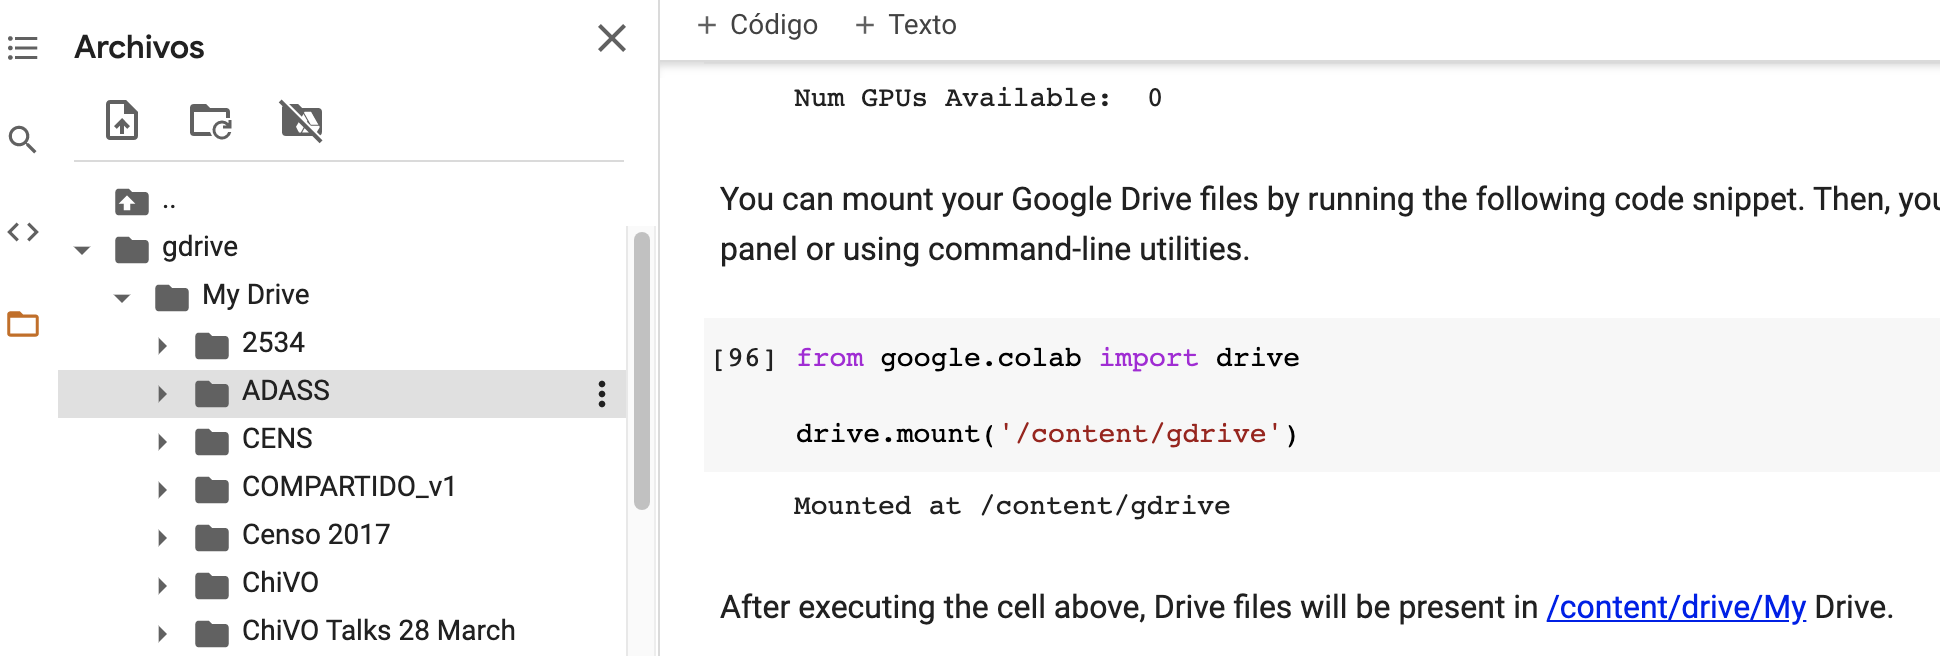

# Overview
Below is an overview of the 6 steps in the U-NET network model life-cycle that we are going to look at:

1. Downloading and Analyze the dataset
2. Prepare the dataset
3. Create the model
4. Compile the model
5. Fit the model
6. Evaluate the model

# Downloading and Analyze the dataset

Download the galaxy image dataset and its masks. Dataset structure:
```
dataset.tar.gz
|- "galImages" directory
  |- jpg image files of training data
|- "galMasks" directory
  |- PNG  gray scale images (ground truth) values of the corresponding images 
```



In [7]:
!ls /content/gdrive/My\ Drive/ADASS/dataset

galImages  galMasks


In [25]:
!mkdir /content/gdrive/My\ Drive/ADASS/test

In [27]:
!wget https://adass2020.s3.amazonaws.com/unet_dataset.tar.gz -P /content/gdrive/My\ Drive/ADASS/test

--2020-11-08 11:14:16--  https://adass2020.s3.amazonaws.com/unet_dataset.tar.gz
Resolving adass2020.s3.amazonaws.com (adass2020.s3.amazonaws.com)... 52.217.71.4
Connecting to adass2020.s3.amazonaws.com (adass2020.s3.amazonaws.com)|52.217.71.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1747960 (1.7M) [application/x-gzip]
Saving to: ‘/content/gdrive/My Drive/ADASS/test/unet_dataset.tar.gz’

unet_dataset.tar.gz 100%[===================>]   1.67M  --.-KB/s    in 0.04s   

2020-11-08 11:14:16 (37.9 MB/s) - ‘/content/gdrive/My Drive/ADASS/test/unet_dataset.tar.gz’ saved [1747960/1747960]



Untar the dataset and verify that it was downloaded

In [28]:
!tar -xvf /content/gdrive/My\ Drive/ADASS/test/unet_dataset.tar.gz -C /content/gdrive/My\ Drive/ADASS/test

dataset/
dataset/galMasks/
dataset/galMasks/Dr7_587741421640614087_S_0.png
dataset/galMasks/Dr7_588015509275541640_S_0.png
dataset/galMasks/Dr7_587729781202813606_E_0.png
dataset/galMasks/Dr7_587736916222673296_S_0.png
dataset/galMasks/Dr7_587728880871473337_S_0.png
dataset/galMasks/Dr7_587739098060488789_E_0.png
dataset/galMasks/Dr7_587736915686457836_S_0.png
dataset/galMasks/Dr7_587731512612356113_E_0.png
dataset/galMasks/Dr7_587738195573604699_S_0.png
dataset/galMasks/Dr7_588015509280129108_S_0.png
dataset/galMasks/Dr7_587745244702048337_E_0.png
dataset/galMasks/Dr7_588017605237276690_E_0.png
dataset/galMasks/Dr7_588017110225715332_S_0.png
dataset/galMasks/Dr7_587731500260720792_S_0.png
dataset/galMasks/Dr7_587739097524404380_E_0.png
dataset/galMasks/Dr7_587733604256383213_E_0.png
dataset/galMasks/Dr7_587733197845102706_E_0.png
dataset/galMasks/Dr7_587728947974439122_S_0.png
dataset/galMasks/Dr7_587731512074567792_S_0.png
dataset/galMasks/Dr7_587729776373268725_S_0.png
dataset/galMa

In [10]:
%ls /content/gdrive/My\ Drive/ADASS/test

02_train_transferlearning_zoo1-Astro.ipynb
data/
dataset/
dataset.tar.gz
mask/
Part_Instance_Segmentation_inference.ipynb
Part_Instance_Segmentation_MASK_RCNN.ipynb
Part_Segmentation.ipynb
unet.ipynb


# Loading the Dataset

The type of data we are going to manipulate consist in:
* an jpg image with 3 channels (RGB) of 256×256 pixels.
* a png mask with 1 channel. (Gray scale images which are the actual ground truth values of the corresponding images).

### Defining the root directory path and data folders


In [11]:
_data_path = '/content/gdrive/My Drive/ADASS/dataset'
_data_input = "galImages"
_data_annot = "galMasks"

In [12]:
input_dir = os.path.join(_data_path , _data_input)
annot_dir = os.path.join(_data_path , _data_annot)

In [13]:
# Image size that we are going to use
img_size = (160, 160)
# Our images are RGB (3 channels)     
n_classes = 3

In [14]:
# the following list comprehension reads the filenames from the input folder
input_paths = [os.path.join(input_dir, i) for i in os.listdir(input_dir) if i.endswith(".jpg") and not i.endswith("(1).jpg")]
annot_paths = [os.path.join(annot_dir, i) for i in os.listdir(annot_dir) if i.endswith(".png") and not (i.startswith(".") or i.endswith("(1).png"))] 

### Sorting the input paths as it will be handy in creating a zip


In [15]:
input_paths, annot_paths = sorted(input_paths), sorted(annot_paths)
print("input_paths = {}".format(len(input_paths)))
print("annot_paths = {}".format(len(annot_paths)))

input_paths = 172
annot_paths = 172


### Verifying the paths

In [16]:
count = 0
for i, j in zip(input_paths, annot_paths):
    print("{} --> {}".format(i, j))
    if count == 5:
        break
    count += 1

/content/gdrive/My Drive/ADASS/dataset/galImages/Dr7_587722982823493798.jpg --> /content/gdrive/My Drive/ADASS/dataset/galMasks/Dr7_587722982823493798_S_0.png
/content/gdrive/My Drive/ADASS/dataset/galImages/Dr7_587722984429322385.jpg --> /content/gdrive/My Drive/ADASS/dataset/galMasks/Dr7_587722984429322385_S_0.png
/content/gdrive/My Drive/ADASS/dataset/galImages/Dr7_587724648183234671.jpg --> /content/gdrive/My Drive/ADASS/dataset/galMasks/Dr7_587724648183234671_E_0.png
/content/gdrive/My Drive/ADASS/dataset/galImages/Dr7_587724649259860103.jpg --> /content/gdrive/My Drive/ADASS/dataset/galMasks/Dr7_587724649259860103_E_0.png
/content/gdrive/My Drive/ADASS/dataset/galImages/Dr7_587725039552888917.jpg --> /content/gdrive/My Drive/ADASS/dataset/galMasks/Dr7_587725039552888917_E_0.png
/content/gdrive/My Drive/ADASS/dataset/galImages/Dr7_587725040093298701.jpg --> /content/gdrive/My Drive/ADASS/dataset/galMasks/Dr7_587725040093298701_E_0.png


### Checking what does an input image and it's corresponding mask looks like


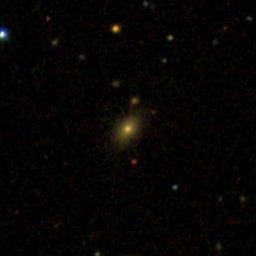

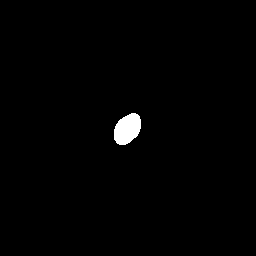

In [17]:
display(Image(input_paths[3]))
PIL.ImageOps.autocontrast(load_img(annot_paths[3]))

In [18]:
import skimage.io
image = skimage.io.imread(annot_paths[3])

In [19]:
image.shape

(256, 256)

# Create the model

### Create a dataloader class

In [20]:
class Dataloader(keras.utils.Sequence):
    """
    helper class to iterate over the data
    """
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, index):
        """
        returns tuple (input, target) corresponds to the batch index
        """
        i = index * self.batch_size
        batch_input_img_paths = self.input_img_paths[i: i+self.batch_size]
        batch_target_img_paths = self.target_img_paths[i: i+self.batch_size]
        x = np.zeros((batch_size,) + self.img_size + (3,), dtype = "float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size = self.img_size)
            x[j] = img
        y = np.zeros((batch_size,) + self.img_size + (1,), dtype = "uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size = self.img_size, color_mode = "grayscale")
            y[j] = np.expand_dims(img, 2)
        return x, y

## Define U-Net architecture

Note that in the original paper, the size of the input image is 572x572x3, however, we will use input image of size 160x160x3. Hence the size at various locations will differ from that in the original paper but the core components remain the same.

In [21]:
#(IMG_SIZE, IMG_SIZE, N_CHANNELS)
input_ = keras.Input(shape = img_size + (3,))

In [22]:
input_

<tf.Tensor 'input_1:0' shape=(None, 160, 160, 3) dtype=float32>

### The Contracting Path (Encoder)
----
The contracting path looks like below. The image is from the official U-Net paper. The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of two 3×3 convolutions, each followed by a batchnormalization layer and a rectified linear unit (ReLU) activation and dropout and a 2×2 max pooling operation with stride 2 for downsampling. At each downsampling step we double the number of feature channels. The purpose of this contracting path is to capture the context of the input image in order to be able to do segmentation.

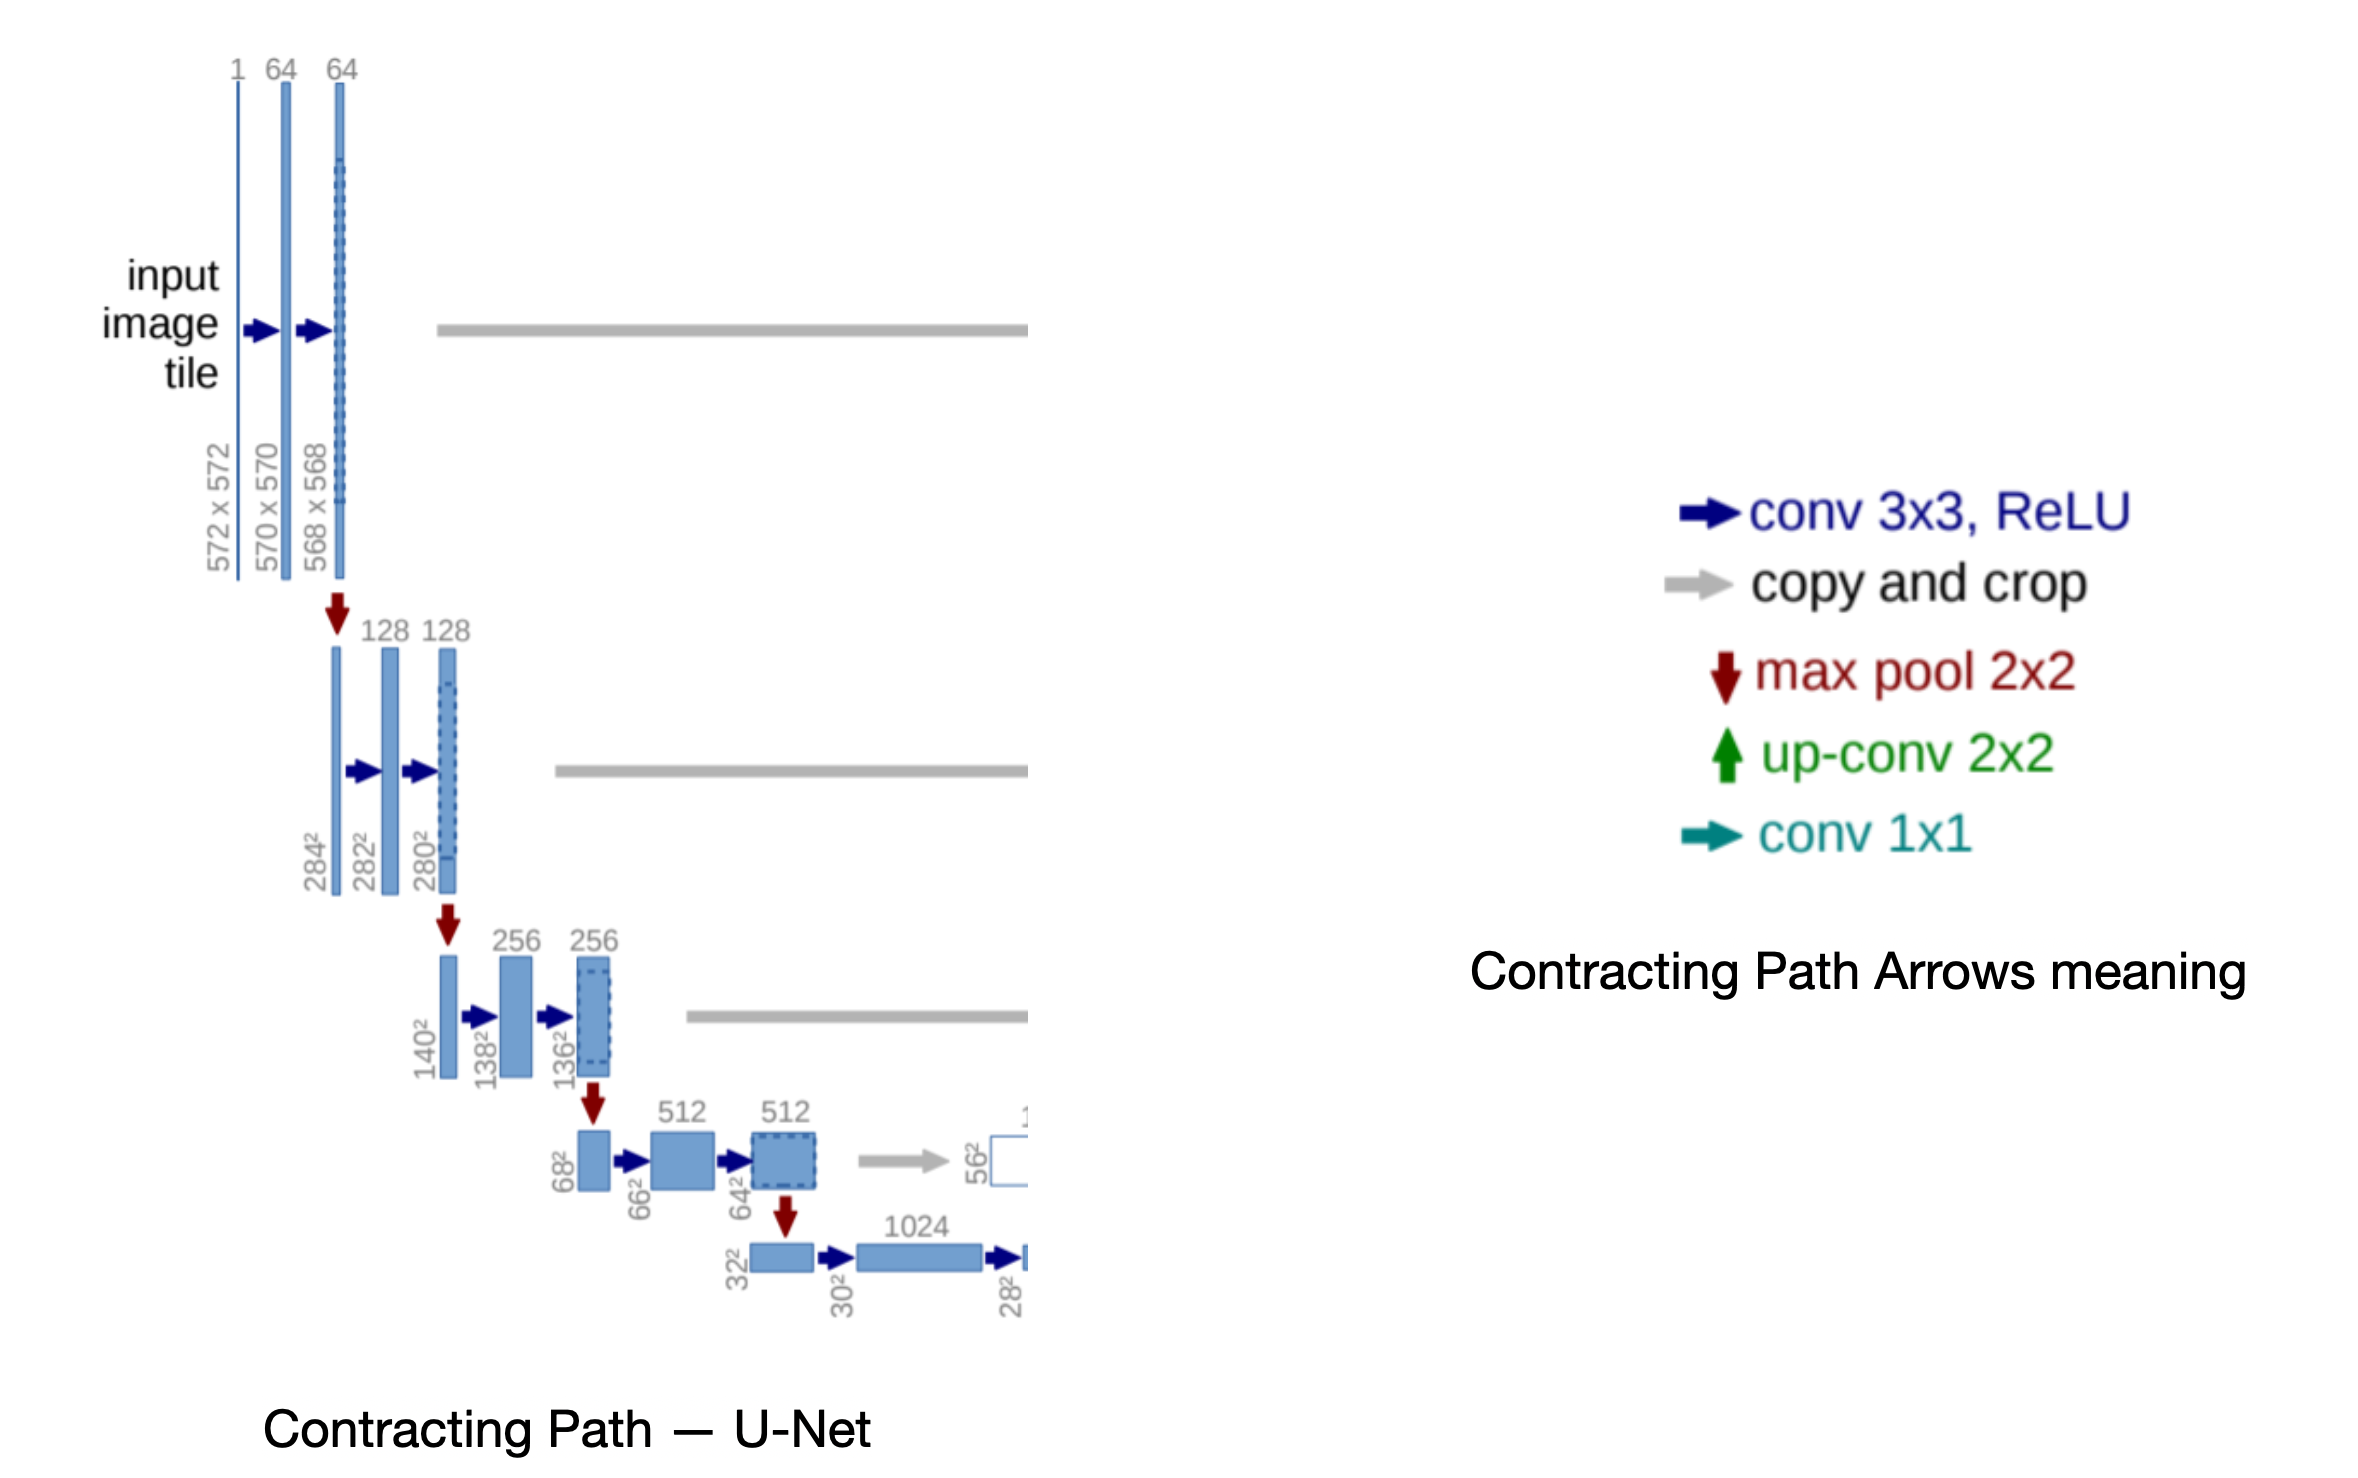

In [23]:
    x = layers.Conv2D(32, 3, strides = 2, padding = "same")(input_)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica

In [24]:
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding = "same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding = "same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides = 2, padding = "same")(x)

        # residuals
        resid = layers.Conv2D(filters, 1, strides = 2, padding = "same")(
            previous_block_activation
        )
        x = layers.add([x, resid])    # add resid block
        previous_block_activation = x

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:

### The Expansive Part (Dencoder)

----
The Expansive path looks like below. The image is from the official U-Net paper. Every step in the expansive path consists of an upsampling of the feature map followed by a 2×2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly feature map from the contracting path, and two 3×3 convolutions, each followed by batchnorm, dropout and a ReLU. The purpose of this expanding path is to enable precise localization combined with contextual information from the contracting path.Every step in the expansive path consists of an upsampling of the feature map followed by a 2×2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly feature map from the contracting path, and two 3×3 convolutions, each followed by batchnorm, dropout and a ReLU. The purpose of this expanding path is to enable precise localization combined with contextual information from the contracting path.

In [29]:
previous_block_activation = x    # residual

In [30]:
    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding = "same")(x)
        x = layers.BatchNormalization()(x)


        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding = "same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # residuals
        resid = layers.UpSampling2D(2)(previous_block_activation)
        resid = layers.Conv2D(filters, 1, padding = "same")(resid)
        x = layers.add([x, resid])
        previous_block_activation = x 

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica

In [31]:
output_ = layers.Conv2D(n_classes, 3, 
                        activation = "softmax", 
                        padding = "same")(x)
unet_model = keras.Model(input_, output_)

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica

In [32]:
unet_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

# Compile the model

In [33]:
# split our img paths into a training and a testing set
test_samples = int(0.3 * len(input_paths))
random.Random(42).shuffle(input_paths)
random.Random(42).shuffle(annot_paths)
train_input_paths = input_paths[:-test_samples]
train_annot_paths = annot_paths[:-test_samples]
testset_input_paths = input_paths[-test_samples:]
testset_annot_paths = annot_paths[-test_samples:]

In [34]:
# split our img paths into a training and a validation set
valid_samples = int(0.1 * len(train_input_paths))
random.Random(42).shuffle(train_input_paths)
random.Random(42).shuffle(train_annot_paths)
trainset_input_paths = train_input_paths[:-valid_samples]
trainset_annot_paths = train_annot_paths[:-valid_samples]
validset_input_paths = train_input_paths[-valid_samples:]
validset_annot_paths = train_annot_paths[-valid_samples:]

In [35]:
print("Train Samples ... {}, {}".format(len(trainset_input_paths), len(trainset_annot_paths)))
print("Valid Samples ... {}, {}".format(len(validset_input_paths), len(validset_annot_paths)))
print("Test Samples ... {}, {}".format(len(testset_input_paths), len(testset_annot_paths)))

Train Samples ... 109, 109
Valid Samples ... 12, 12
Test Samples ... 51, 51


In [36]:
batch_size = 10
epochs = 10

train_generator = Dataloader(batch_size, img_size, trainset_input_paths, trainset_annot_paths)
valid_generator = Dataloader(batch_size, img_size, validset_input_paths, validset_annot_paths)
test_generator = Dataloader(batch_size, img_size, testset_input_paths, testset_annot_paths)

In [37]:
# configure the model for training
unet_model.compile(optimizer = "rmsprop", 
                   loss = "sparse_categorical_crossentropy")
# if no accuracy improvements we can stop the training directly
checkpoint_path = os.path.join(_data_path, "checkpoint", "gal_segmentation.h5")

callbacks = [# to save checkpoints
             keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                             save_best_only = True)]

model_history = unet_model.fit(train_generator, 
                               epochs = epochs, 
                               validation_data = valid_generator, 
                               callbacks = callbacks)

Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:lo

# Evaluation the model

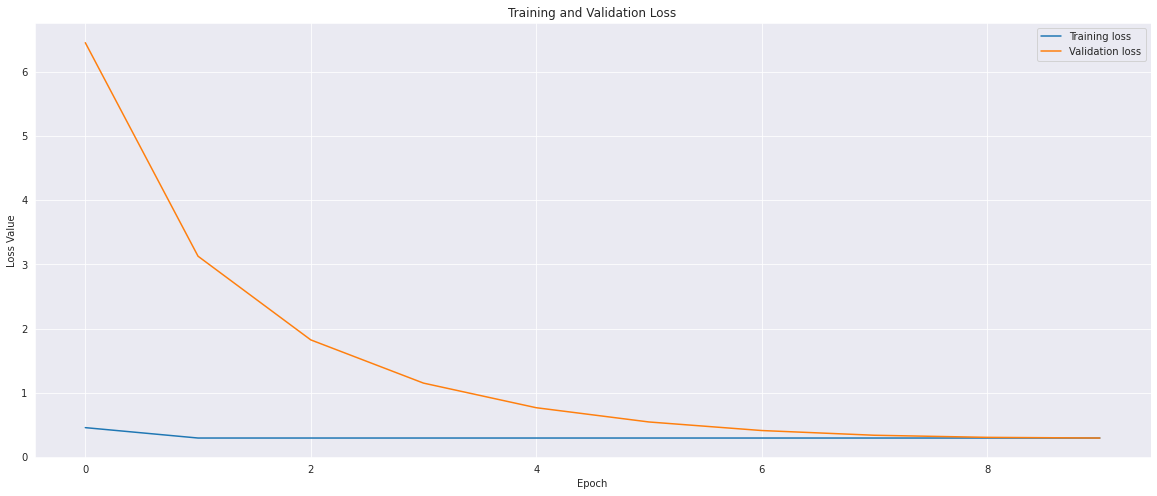

In [38]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

e = range(epochs)

sns.set_style("darkgrid")
plt.figure(figsize = (20, 8))
plt.plot(e, loss,  label='Training loss')
plt.plot(e, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
# plt.ylim([0, 10])
plt.legend()
plt.show()

---
# 05. Model Prediction 

In [ ]:
# load the saved model
#checkpoint_path = os.path.join(_data_path, "checkpoint", "gal_segmentation.h5")
#unet_model = tf.keras.models.load_model(checkpoint_path)

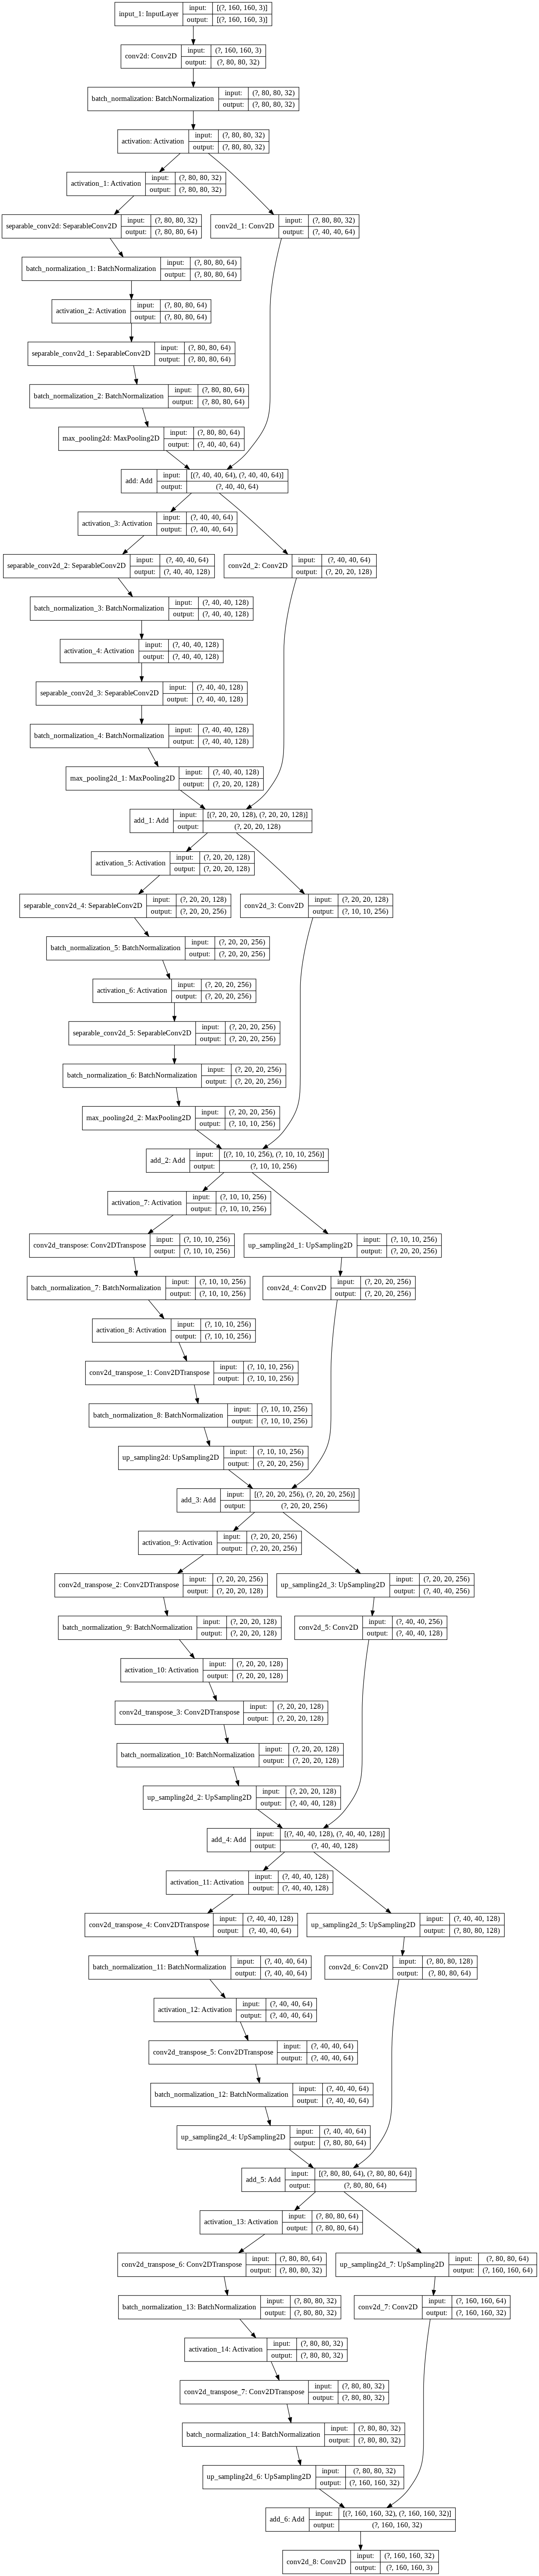

In [39]:
tf.keras.utils.plot_model(unet_model, show_shapes=True)

In [41]:
batch_size = 8
test_generator = Dataloader(batch_size, (160, 160), testset_input_paths[:10], testset_annot_paths[:10])
test_preds = unet_model.predict(test_generator)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op

# Displaying the Results

In the following section, we are displaying the results of the model predictions on the test dataset. 

In [40]:
def display_mask(img_arr, i):
    """
    helper function to display a model's prediction.
    """
    mask = np.argmax(img_arr[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

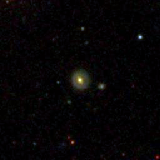

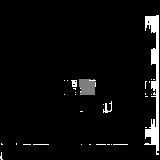

In [42]:
# real Image
display(PIL.ImageOps.autocontrast(load_img(testset_input_paths[0], target_size = (160, 160))))
# predicted Image
display_mask(test_preds, 0)

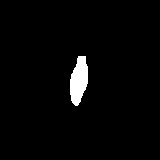

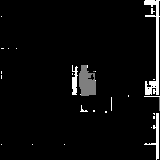

In [43]:
# real Image
display(PIL.ImageOps.autocontrast(load_img(testset_annot_paths[2], target_size = (160, 160), color_mode = "grayscale")))
# predicted Image
display_mask(test_preds, 2)

# Awesome Semantic Segmentation

- https://github.com/mrgloom/awesome-semantic-segmentation

# References

- https://medium.com/analytics-vidhya/creating-a-very-simple-u-net-model-with-pytorch-for-semantic-segmentation-of-satellite-images-223aa216e705

- https://glassboxmedicine.com/2020/01/21/segmentation-u-net-mask-r-cnn-and-medical-applications/

- https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47

- https://medium.com/@pallawi.ds/understand-semantic-segmentation-with-the-fully-convolutional-network-u-net-step-by-step-9d287b12c852